# Gene essentiality

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
def get_genes_of_me(me):
    genes = [m.id.split('_')[1] for m in me.metabolites if isinstance(m,cobrame.TranslatedGene)]
    if 'dummy' in genes:
        genes.remove('dummy')
    return list(set(genes))

In [3]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')
ibsu_directory = join(flat_files.ecoli_files_dir, 'iBsu1103.json') 

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)
ibsu = cobra.io.load_json_model(ibsu_directory)

bsub.optimize()

<Solution 0.12 at 0x7f9dd7a18390>

In [4]:
met = ibsu.reactions[0]

met.gene_reaction_rule

''

In [5]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)
with open('../me_models/final/iJL1678b.pickle', 'rb') as f:
    ecome = pickle.load(f)

## Essentiality

M-model

In [6]:
from bacillusme.analysis import essentiality as es

In [7]:
genes = [gene.id for gene in bsub.genes]
essentiality_df_m,flux_responses_m = es.gene_essentiality(bsub,genes, 'm',NP=1,threshold = 0.01,precision=1e-6)
flux_responses_m.to_csv('essentiality/essentiality_raw_results.csv')

Solving model for base solution


100%|██████████| 844/844 [02:24<00:00,  5.85it/s]


Done


In [8]:
# E. coli
genes = [gene.id for gene in eco.genes]
essentiality_df_m,flux_responses_m = es.gene_essentiality(eco,genes, 'm',NP=1,threshold = 0.01,precision=1e-6)
flux_responses_m.to_csv('essentiality/essentiality_raw_results_eco.csv')

Solving model for base solution


100%|██████████| 1367/1367 [11:58<00:00,  1.90it/s]


Done


ME-model

In [9]:
genes = [gene.id for gene in me.genes]
genes_eco = get_genes_of_me(ecome)

In [ ]:
essentiality_df_me,flux_responses_me = es.gene_essentiality(me,genes,'me',NP=10,threshold = 0.01,precision=1e-6)
flux_responses_me.to_csv('essentiality/essentiality_raw_me_results.csv')

Solving model for base solution


10 threads:   2%|▏         | 21/964 [44:57<23:42:56, 90.54s/it] 

In [ ]:
# E. coli
essentiality_df_me,flux_responses_me = es.gene_essentiality(ecome,genes_eco,'me',NP=10,threshold = 0.01,precision=1e-6)
flux_responses_me.to_csv('essentiality/essentiality_raw_me_results_eco.csv')

Solving model for base solution


10 threads:   1%|          | 8/1568 [18:40<15:27:20, 35.67s/it]   

In [10]:
# Read
flux_responses_m = pd.read_csv('essentiality/essentiality_raw_results.csv',index_col=0)
flux_responses_me = pd.read_csv('essentiality/essentiality_raw_me_results.csv',index_col=0)

flux_responses_m_eco = pd.read_csv('essentiality/essentiality_raw_results_eco.csv',index_col=0)
flux_responses_me_eco = pd.read_csv('essentiality/essentiality_raw_me_results_eco.csv',index_col=0)

In [11]:
essentiality_df_m,_ = es.gene_essentiality(bsub,genes,'m',flux_responses=flux_responses_m)
essentiality_df_me,_ = es.gene_essentiality(me,genes,'me',flux_responses=flux_responses_me)

essentiality_df_m_eco,_ = es.gene_essentiality(eco,genes_eco,'m',flux_responses=flux_responses_m_eco)
essentiality_df_me_eco,_ = es.gene_essentiality(ecome,genes_eco,'me',flux_responses=flux_responses_me_eco)

Done
Done
Done
Done


### Combine results

In [12]:
essentiality_df = essentiality_df_me.join(essentiality_df_m,lsuffix='_me',rsuffix='_m')
essentiality_df_eco = essentiality_df_me_eco.join(essentiality_df_m_eco,lsuffix='_me',rsuffix='_m')

## M/ME comparison

In [13]:
difference_df = essentiality_df[essentiality_df.essentiality_m != essentiality_df.essentiality_me].dropna()
difference_df_eco = essentiality_df_eco[essentiality_df_eco.essentiality_m != essentiality_df_eco.essentiality_me].dropna()

In [14]:
difference_df_eco

,response_me,essentiality_me,response_m,essentiality_m
b0084,1.42316,+,0,0
b0351,-0.553186,-,0,0
b3747,-0.0234864,-,0,0
b0243,-0.378763,-,-0.00091602,0
b2601,1.64346,+,0,0
...,...,...,...,...
b3829,-1,e,0,0
b3956,1.55205,+,-0.00305921,0
b0727,2.26168,+,-0.00473291,0
b2779,-1,e,-0.0788231,-


## Reported essentiality

In [15]:
gene_dictionary = pd.read_csv('../building_data/gene_name_dictionary.csv',index_col=0)
essential_genes = pd.read_csv('./essentiality/subtiwiki_essential.txt',index_col=0,sep='\t')
essential_genes_eco = pd.read_csv('./essentiality/eco_essential.txt',index_col=3,sep='\t')

In [16]:
def get_gene_count(me):
    from Bio import SeqIO
    gb_file = SeqIO.read("../building_data/NC_000964.gb", 'gb')
    gene_count = 0
    for feature in gb_file.features:
        if feature.type not in {'CDS', 'rRNA','tRNA', 'ncRNA'}:
            continue
        gene_count += 1
    return gene_count

In [17]:
gene_count = get_gene_count("../building_data/NC_000964.gb")
gene_count_eco = get_gene_count("../building_data/NC_000913.2.gb")

In [18]:
all_genes = get_genes_of_me(me)
all_genes_eco = get_genes_of_me(ecome)

In [19]:
def get_true_essentiality(essential_genes,all_genes,gene_dictionary=False):
    true_essentiality = {}
    for locus_id in all_genes:
        if isinstance(gene_dictionary,pd.DataFrame):
            name = gene_dictionary.loc[locus_id]['name']
        else:
            name = locus_id
        if name in essential_genes.index.values:
            true_essentiality[locus_id] = 'e'
        else:
            true_essentiality[locus_id] = '0'
    true_essentiality_df = pd.DataFrame({'true_essentiality':true_essentiality})
    return true_essentiality_df

In [20]:
essentiality_df

,response_me,essentiality_me,response_m,essentiality_m
BSU00180,-9.37743e-06,0,-2.96277e-06,0
BSU00270,0,0,-2.53507e-10,0
BSU00150,-0.000243813,0,-9.72943e-05,0
BSU00140,0,0,-2.11555e-09,0
BSU00110,0,0,0,0
...,...,...,...,...
BSU40420,-1,e,-1,e
BSU40550,-1,e,-1,e
BSU41060,-1,e,NaN,NaN
BSU41050,-1,e,NaN,NaN


In [21]:
true_essentiality_df = get_true_essentiality(essential_genes,all_genes,gene_dictionary=gene_dictionary)
true_essentiality_df_eco = get_true_essentiality(essential_genes_eco,all_genes_eco,gene_dictionary=False)

In [22]:
essentiality_df = essentiality_df.join(true_essentiality_df)
essentiality_df_eco = essentiality_df_eco.join(true_essentiality_df_eco)

In [23]:
essentiality_df

,response_me,essentiality_me,response_m,essentiality_m,true_essentiality
BSU00180,-9.37743e-06,0,-2.96277e-06,0,0
BSU00270,0,0,-2.53507e-10,0,0
BSU00150,-0.000243813,0,-9.72943e-05,0,0
BSU00140,0,0,-2.11555e-09,0,0
BSU00110,0,0,0,0,0
...,...,...,...,...,...
BSU40420,-1,e,-1,e,0
BSU40550,-1,e,-1,e,e
BSU41060,-1,e,NaN,NaN,0
BSU41050,-1,e,NaN,NaN,e


In [ ]:
essentiality_df.to_csv('essentiality/essentiality_results.csv')
essentiality_df_eco.to_csv('essentiality/essentiality_results_eco.csv')

### Read

In [ ]:
# Read
essentiality_df = pd.read_csv('essentiality/essentiality_results.csv',index_col=0)
essentiality_df_eco = pd.read_csv('essentiality/essentiality_results_eco.csv',index_col=0)

In [29]:
essentiality_df.loc['BSU37150']

response_me         -1
essentiality_me      e
response_m          -1
essentiality_m       e
true_essentiality    e
Name: BSU37150, dtype: object

In [ ]:
# essentiality_df = essentiality_df.dropna()
# essentiality_df_eco = essentiality_df_eco.dropna()

In [24]:
def get_scores(essentiality_df,gene_count):
    models = ['m','me']
    scores = {}
    for m in models:
        scores[m] = {}

        field = 'essentiality_{}'.format(m)
        P = essentiality_df[(essentiality_df[field]=='e')].shape[0]
        N = essentiality_df[(essentiality_df[field]=='0')].shape[0]
        TP = essentiality_df[essentiality_df[field]=='e'][essentiality_df.true_essentiality=='e'].shape[0]
        FP = P-TP
        TN = essentiality_df[essentiality_df[field]=='0'][essentiality_df.true_essentiality=='0'].shape[0]
        FN = N-TN

        FDR = FP/(FP+TP)
        precision = TP/(TP+FP)
        TPR = TP/(TP+FN)
        MCC = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        coverage = (P+N)/gene_count

        print(TP,FP,TN,FN)

        scores[m]['Precision'] = precision
        scores[m]['FDR'] = FDR
        scores[m]['TPR'] = TPR
        scores[m]['MCC'] = MCC
        scores[m]['Coverage'] = coverage

    scores_df = pd.DataFrame.from_dict(scores)
    return scores_df

In [25]:
len(essentiality_df['essentiality_me'].loc[essentiality_df['essentiality_me']=='e'])

311

In [26]:
scores_df = get_scores(essentiality_df,gene_count)
scores_df_eco = get_scores(essentiality_df_eco,gene_count_eco)

57 117 579 23
143 168 603 20
92 110 983 141
232 177 904 98


/home/jt/me_modeling/lib/python3.6/site-packages/ipykernel_launcher.py:10 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/me_modeling/lib/python3.6/site-packages/ipykernel_launcher.py:12 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
scores_df.plot.bar()
plt.ylabel('Score')
plt.savefig('figures/essentiality_scores.svg',format='SVG')

In [30]:
scores_df

,m,me
Precision,0.327586,0.459807
FDR,0.672414,0.540193
TPR,0.712500,0.877301
MCC,0.396910,0.531064
Coverage,0.174657,0.210218


In [ ]:
scores_df_eco.plot.bar()
plt.ylabel('Score')

In [ ]:
all_scores_df = scores_df.join(scores_df_eco,lsuffix='_bsub',rsuffix='_eco')
all_scores_df.plot.bar()
plt.ylabel('Score')
plt.savefig('figures/essentiality_scores_comparison.svg',format='SVG')
plt.tight_layout()

In [118]:
all_scores_df['m_bsub'] - all_scores_df['me_bsub']

Precision   -0.132221
FDR          0.132221
TPR         -0.164801
MCC         -0.134008
Coverage    -0.035336
dtype: float64

In [117]:
(all_scores_df['m_bsub'] - all_scores_df['me_bsub']).div(all_scores_df['m_bsub'])

Precision   -0.403622
FDR          0.196636
TPR         -0.231299
MCC         -0.337628
Coverage    -0.202320
dtype: float64

In [ ]:
(965-844)/844

### Essentiality pie chart

In [277]:
essentiality_df[essentiality_df['essentiality_me']==0]

,response_me,essentiality_me,response_m,essentiality_m
BSU00140,0.000000,0,-2.150779e-10,0
BSU00180,0.000000,0,-2.960415e-06,0
BSU00150,-0.000234,0,-9.729447e-05,0
BSU00090,0.000000,0,-3.719203e-10,0
BSU00270,0.000000,0,-1.300703e-10,0
BSU00120,0.000000,0,-1.441039e-10,0
BSU00110,0.000000,0,-1.441039e-10,0
BSU00410,0.000000,0,NaN,NaN
BSU00680,-0.000234,0,-9.729473e-05,0
BSU00730,0.000000,0,-3.456350e-10,0


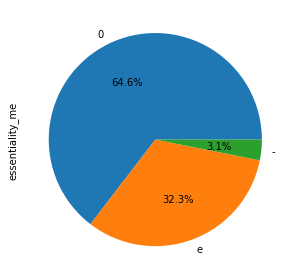

In [314]:
essentiality_df['essentiality_me'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/essentiality_scores.svg',format='SVG')
plt.tight_layout()

In [312]:
essentiality_df['essentiality_me'].value_counts()

0    622
e    311
-     30
Name: essentiality_me, dtype: int64

In [313]:
essentiality_df['essentiality_me'].value_counts().div(essentiality_df['essentiality_me'].value_counts().sum())

0    0.645898
e    0.322949
-    0.031153
Name: essentiality_me, dtype: float64

In [76]:
def get_gene_annotation(me,model):
    gene_annotation = {}
    for m in tqdm(me.metabolites):
        if isinstance(m,cobrame.TranslatedGene):
            gene_id = m.id.split('_')[-1]
            if hasattr(model.genes,gene_id):
                gene = model.genes.get_by_id(gene_id)
                for r in gene.reactions:
                    gene_annotation[gene_id] = r.subsystem
            else:
                rxns = get_final_reactions_of_gene(me,gene_id)
                if rxns:
                    subsystem = rxns[0].id.split('_')[-0]
                else:
                    subsystem = 'no_rxn'
                gene_annotation[gene_id] = subsystem
    return gene_annotation

In [ ]:
subsystem = list(set([i.id.split('_')[0] for i in final_rxns if active_complex not in i.id]))

In [78]:
gene_annotation = get_gene_annotation(me,bsub)





  0%|          | 0/4214 [00:00<?, ?it/s]



 52%|█████▏    | 2173/4214 [00:00<00:00, 4774.13it/s]



 55%|█████▍    | 2317/4214 [00:05<00:20, 92.93it/s]  



 57%|█████▋    | 2419/4214 [00:05<00:14, 127.05it/s]



 60%|█████▉    | 2528/4214 [00:05<00:09, 172.12it/s]



 62%|██████▏   | 2627/4214 [00:12<00:39, 40.60it/s] 



 64%|██████▍   | 2703/4214 [00:12<00:27, 55.50it/s]



 66%|██████▌   | 2763/4214 [00:13<00:21, 67.14it/s]



 67%|██████▋   | 2809/4214 [00:15<00:34, 40.77it/s]



 70%|██████▉   | 2946/4214 [00:15<00:22, 57.49it/s]



 71%|███████▏  | 3010/4214 [00:17<00:26, 44.61it/s]



100%|██████████| 4214/4214 [00:18<00:00, 232.01it/s][A


In [70]:
annotation_df = pd.DataFrame.from_dict({'annotation':gene_annotation})
annotation_df.to_csv('gene_annotation.csv')

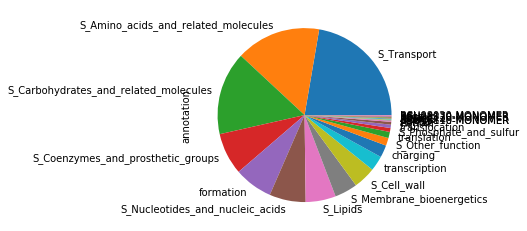

In [79]:
annotation_df['annotation'].value_counts().plot.pie()

#### Essential genes

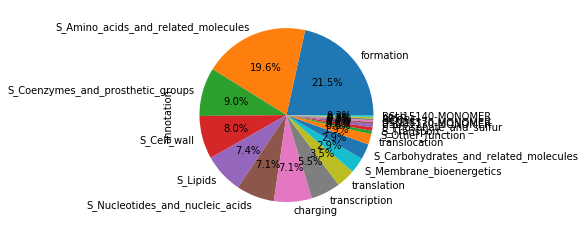

In [80]:
annotation_df.loc[essentiality_df[essentiality_df['essentiality_me']=='e'].index]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/essential_genes_pie.svg',format='SVG')
#plt.tight_layout()

In [56]:
annotation_df.loc[essentiality_df[essentiality_df['essentiality_me']=='e'].index]['annotation'].value_counts()

                                         126
S_Amino_acids_and_related_molecules       62
S_Coenzymes_and_prosthetic_groups         28
S_Cell_wall                               25
S_Lipids                                  23
S_Nucleotides_and_nucleic_acids           22
S_Carbohydrates_and_related_molecules      9
S_Membrane_bioenergetics                   9
S_Other_function                           3
S_Transport                                2
S_Phosphate_and_sulfur                     2
Name: annotation, dtype: int64

In [328]:
annotation_df.loc[annotation_df['annotation']=='formation']

,annotation
BSU00410,formation
BSU00990,formation
BSU01020,formation
BSU01030,formation
BSU01040,formation
...,...
BSU40500,formation
BSU40890,formation
BSU40910,formation
BSU41050,formation


#### Non-essential genes

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


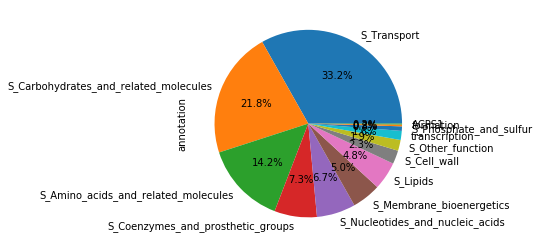

In [319]:
annotation_df.loc[essentiality_df[essentiality_df['essentiality_me']!='e'].index]['annotation'].value_counts().plot.pie(autopct='%1.1f%%')
plt.savefig('figures/non_essential_genes_pie.svg',format='SVG')
plt.tight_layout()

#### Errors

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


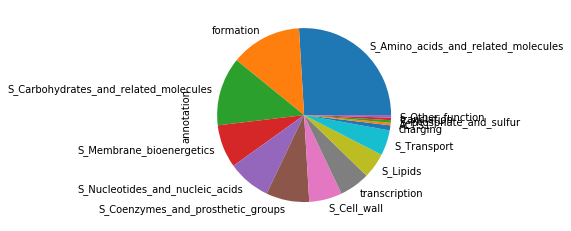

In [307]:
annotation_df.loc[essentiality_df[essentiality_df['essentiality_me']!=essentiality_df['true_essentiality']].index]['annotation'].value_counts().plot.pie()

In [309]:
essentiality_df[essentiality_df['essentiality_me']!=essentiality_df['true_essentiality']]

,response_me,essentiality_me,response_m,essentiality_m,true_essentiality
BSU00550,-1.0,e,NaN,NaN,0
BSU00500,-1.0,e,-1.0,e,0
BSU00750,-1.0,e,-1.0,e,0
BSU00740,-1.0,e,-1.0,e,0
BSU00760,-1.0,e,-1.0,e,0
...,...,...,...,...,...
BSU38520,-1.0,e,-1.0,e,0
BSU40500,-1.0,e,NaN,NaN,0
BSU41060,-1.0,e,NaN,NaN,0
BSU40910,-1.0,e,NaN,NaN,0


In [82]:
essentiality_df.loc['BSU22670']

response_me         -1
essentiality_me      e
response_m          -1
essentiality_m       e
true_essentiality    0
Name: BSU22670, dtype: object

In [360]:
for gene in annotation_df.index:
    if 'Carbohydrate' in annotation_df.loc[gene]['annotation'] and essentiality_df.loc[gene]['essentiality_me']=='e':
        gene = bsub.genes.get_by_id(gene)
        for r in gene.reactions:
            print(gene.id,r.id, r.name,r.reaction)

BSU00460 CDPMEK 4-(cytidine 5'-diphospho)-2-C-methyl-D-erythritol kinase 4c2me_c + atp_c --> 2p4c2me_c + adp_c + h_c
BSU01770 PGMT Phosphoglucomutase g1p_c <=> g6p_c
BSU01770 PGAMT Phosphoglucosamine mutase gam1p_c <=> gam6p_c
BSU16550 DXPRIi 1-deoxy-D-xylulose reductoisomerase dxyl5p_c + h_c + nadph_c --> 2me4p_c + nadp_c
BSU17890 TKT1 Transketolase r5p_c + xu5p__D_c <=> g3p_c + s7p_c
BSU17890 TKT2 Transketolase e4p_c + xu5p__D_c <=> f6p_c + g3p_c
BSU22830 G3PD1ir Glycerol 3 phosphate dehydrogenase  NAD  dhap_c + h_c + nadh_c <=> glyc3p_c + nad_c
BSU24270 DXPS 1-deoxy-D-xylulose 5-phosphate synthase g3p_c + h_c + pyr_c --> co2_c + dxyl5p_c
BSU29190 PFK Phosphofructokinase atp_c + f6p_c --> adp_c + fdp_c + h_c
BSU29190 PFK_2 Phosphofructokinase atp_c + tag6p__D_c --> adp_c + h_c + tagdp__D_c
BSU33900 ENO Enolase 2pg_c <=> h2o_c + pep_c
BSU35660 UAG2E UDP-N-acetylglucosamine 2-epimerase uacgam_c <=> uacmam_c
BSU35660 UAG2EMA UDP-N-acetyl-D-glucosamine 2-epimerase (Hydrolysis) h2o_c + ua

In [363]:
for gene in annotation_df.index:
    if 'Amino' in annotation_df.loc[gene]['annotation'] and essentiality_df.loc[gene]['essentiality_me']=='e':
        gene = bsub.genes.get_by_id(gene)
        for r in gene.reactions:
            print(gene.id,r.id, r.name,r.reaction)

BSU00750 ADCS 4-amino-4-deoxychorismate synthase chor_c + gln__L_c --> 4adcho_c + glu__L_c
BSU00750 ANS Anthranilate synthase chor_c + gln__L_c --> anth_c + glu__L_c + h_c + pyr_c
BSU01780 GF6PTA Glutamine-fructose-6-phosphate transaminase f6p_c + gln__L_c --> gam6p_c + glu__L_c
BSU03150 SHKK Shikimate kinase atp_c + skm_c --> adp_c + h_c + skm5p_c
BSU04640 ALAR Alanine racemase ala__L_c <=> ala__D_c
BSU04740 PSP_L Phosphoserine phosphatase (L-serine) h2o_c + pser__L_c --> pi_c + ser__L_c
BSU04740 PSP_D Phosphoserine phosphatase  D serine  h2o_c + pser__D_c --> pi_c + ser__D_c
BSU10020 PSERT Phosphoserine transaminase 3php_c + glu__L_c <=> akg_c + pser__L_c
BSU11190 AGPR N-acetyl-g-glutamyl-phosphate reductase acg5sa_c + nadp_c + pi_c <=> acg5p_c + h_c + nadph_c
BSU11200 ACGS N-acetylglutamate synthase accoa_c + glu__L_c --> acglu_c + coa_c + h_c
BSU11200 ORNTAC_1 Ornithine transacetylase acorn_c + glu__L_c <=> acglu_c + orn__L_c
BSU11210 ACGK Acetylglutamate kinase acglu_c + atp_c -->

In [84]:
exchange_single_model(me)

,name,reaction,lower_bound,upper_bound,flux
id,,,,,
EX_co2_e,,co2_e <=>,-999999.0,999999.0,6.044420e+00
EX_cobalt2_e,,cobalt2_e <=>,-1000.0,0.0,-4.854562e-08
EX_glc__D_e,,glc__D_e <=>,-1.7,999999.0,-1.699990e+00
EX_h2o_e,,h2o_e <=>,-999999.0,999999.0,8.428708e+00
EX_h_e,,h_e <=>,-999999.0,999999.0,7.870135e-01
EX_k_e,,k_e <=>,-999999.0,999999.0,-1.808661e-07
EX_mg2_e,,mg2_e <=>,-999999.0,999999.0,-1.309331e-03
EX_mn2_e,,mn2_e <=>,-1000.0,0.0,-2.372348e-06
EX_nh4_e,,nh4_e <=>,-5.0,999999.0,-9.474726e-01


In [85]:
me.solution.f

0.1017141342163086